# Case Study

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score,GridSearchCV,RandomizedSearchCV
import folium
from folium.plugins import MarkerCluster
%matplotlib inline

pd.set_option("display.max_columns",500)
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset=pd.read_csv("data/rentals.csv")
dataset.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


In [3]:
dataset.shape

(8111, 9)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


In [5]:
df= dataset.copy()

# Data Validation 
#### Cleaning Data

In [6]:
df['price']=df['price'].apply(lambda x: x.split('$')[1].replace(',','')).astype(float)

In [7]:
df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 570.4+ KB


In [9]:
categorical_columns=["property_type","room_type"]
numerical_columns = [i for i in df.columns if i not in categorical_columns]
print(f"categorical columns : {categorical_columns}")
print(f"numerical columns : {numerical_columns}")

categorical columns : ['property_type', 'room_type']
numerical columns : ['id', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'minimum_nights', 'price']


#### Searching Missing Values

In [10]:
#Missing values
df.isna().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

In [11]:
df[df['bedrooms'].isna()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
269,431862,37.78321,-122.41969,Apartment,Entire home/apt,1.0,NaN,30,124.0
6301,32183178,37.78883,-122.48640,House,Entire home/apt,3.5,NaN,30,650.0
7786,38329898,37.78347,-122.41669,Apartment,Entire home/apt,1.0,NaN,30,75.0
7840,38550933,37.78979,-122.41994,Apartment,Entire home/apt,1.0,NaN,30,108.0


In [12]:
df[df['bathrooms'].isna()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
139,144978,37.79336,-122.42506,Apartment,Private room,NaN,1.0,30,56.0
181,229240,37.79341,-122.40340,Hostel,Shared room,NaN,1.0,1,45.0
196,259621,37.79470,-122.40374,Hostel,Shared room,NaN,1.0,1,45.0
197,259622,37.79441,-122.40473,Hostel,Shared room,NaN,1.0,1,45.0
267,430692,37.75906,-122.40761,Apartment,Private room,NaN,1.0,31,68.0
352,596042,37.79384,-122.42436,Apartment,Private room,NaN,1.0,30,63.0
434,785901,37.79313,-122.40443,Hostel,Shared room,NaN,1.0,1,45.0
435,786492,37.79421,-122.40310,Hostel,Shared room,NaN,1.0,1,45.0
436,786506,37.79260,-122.40339,Hostel,Shared room,NaN,1.0,1,45.0
539,1031899,37.74833,-122.42621,Apartment,Entire home/apt,NaN,1.0,30,127.0


#### Imputing Missing Values

In [13]:
#imputing missing bedroom value filling 4 where bathrrom is 3.5 
#and filling 1.0 in rest based on median
df[(df['bathrooms']==3.5) & (df['property_type']=='House')]['bedrooms'].median()

4.0

In [14]:
df.loc[6301,"bedrooms"]=4.0

In [15]:
df[(df['bathrooms']==1) & (df['property_type']=='Apartment')]['bedrooms'].median()

1.0

In [16]:
df['bedrooms']=df['bedrooms'].fillna(1.0)

 Filling missing values of bathrooms based on median for property types with 1 bedrooms

In [17]:
df[(df['bedrooms']==1) & (df['property_type']=='Apartment')]['bathrooms'].median()

1.0

In [18]:
df[(df['bedrooms']==1) & (df['property_type']=='Hostel')]['bathrooms'].median()

2.0

In [19]:
df[(df['bedrooms']==1) & (df['property_type']=='Apartment')&(df['room_type']=='Entire home/apt')]['bathrooms'].median()

1.0

In [20]:
df.loc[(df['bedrooms']==1) & (df['property_type']=='Apartment')& (df['bathrooms'].isna()),'bathrooms']=1.0

In [21]:
df['bathrooms']=df['bathrooms'].fillna(2.0)

# Data Visualization
#### Exploratory Data Analysis

In [22]:
lat_lon_pairs=list(zip(list(df.latitude),list(df.longitude)))
map=folium.Map(location=[ 37.79336,-122.42506 ],width='75%', height='75%')

In [23]:
MarkerCluster(lat_lon_pairs,overlay=False).add_to(map)
map

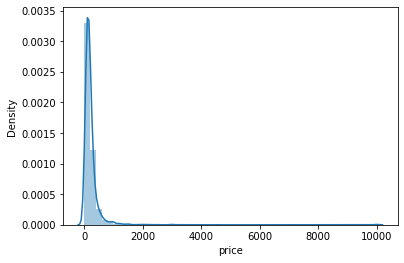

In [24]:
#distribution of price 
sns.distplot(df.price)
plt.show()

In [25]:
#types of property
print(f"no of types of properties : {len(df['property_type'].value_counts())}")
df['property_type'].value_counts()

no of types of properties : 26


Apartment             3243
House                 2314
Condominium            892
Guest suite            577
Boutique hotel         267
Hotel                  157
Townhouse              142
Serviced apartment     121
Hostel                  92
Loft                    88
Bed and breakfast       43
Aparthotel              41
Guesthouse              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Cabin                    3
Tiny house               3
Earth house              2
Dome house               1
Camper/RV                1
Hut                      1
In-law                   1
Name: property_type, dtype: int64

In [26]:
#types of rooms
print(f"no of types of rooms : {len(df['room_type'].value_counts())}")
df['room_type'].value_counts()

no of types of rooms : 4


Entire home/apt    4772
Private room       2891
Shared room         241
Hotel room          207
Name: room_type, dtype: int64

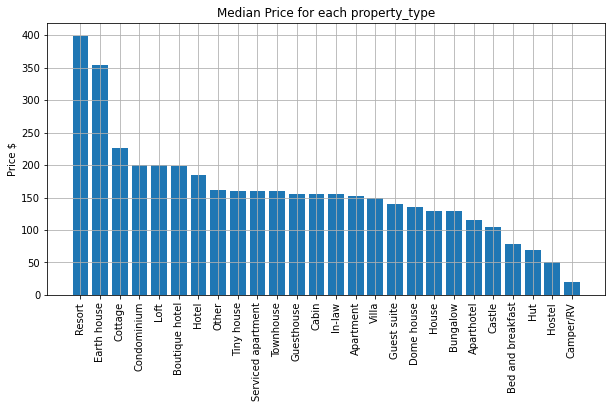

property_type
Resort                399.0
Earth house           354.5
Cottage               227.0
Condominium           200.0
Loft                  200.0
Boutique hotel        199.0
Hotel                 185.0
Other                 162.0
Tiny house            160.0
Serviced apartment    160.0
Townhouse             159.5
Guesthouse            155.0
Cabin                 155.0
In-law                155.0
Apartment             153.0
Villa                 149.5
Guest suite           140.0
Dome house            135.0
House                 130.0
Bungalow              130.0
Aparthotel            116.0
Castle                104.5
Bed and breakfast      79.0
Hut                    69.0
Hostel                 50.0
Camper/RV              20.0
Name: price, dtype: float64

In [27]:
#Visualization of data
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.grid()
plt.ylabel("Price $")
plt.title("Median Price for each property_type")
plt.bar(x=df.groupby("property_type")["price"].median().sort_values(ascending=False).index,height=df.groupby("property_type")["price"].median().sort_values(ascending=False).values)
plt.show()
df.groupby("property_type")["price"].median().sort_values(ascending=False)

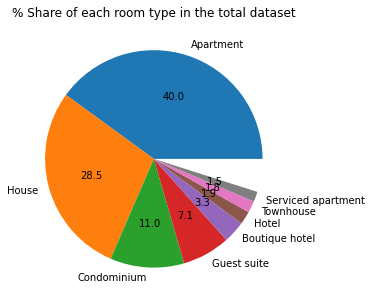

In [28]:
plt.figure(figsize=(5,5))
plt.pie(df['property_type'].value_counts(normalize=True)[0:8],labels=df['property_type'].value_counts(normalize=True).index[0:8],autopct="%.1f")
plt.title("% Share of each room type in the total dataset")
plt.show()

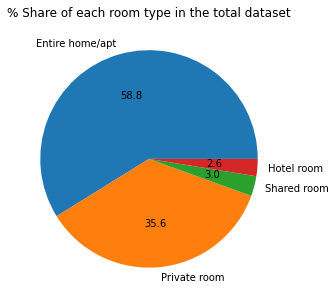

In [29]:
plt.figure(figsize=(5,5))
plt.pie(df['room_type'].value_counts(normalize=True),labels=df['room_type'].value_counts(normalize=True).index,autopct="%.1f")
plt.title("% Share of each room type in the total dataset")
plt.show()

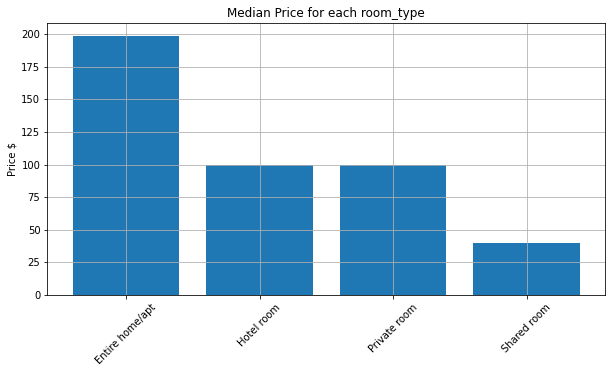

room_type
Entire home/apt    198.5
Hotel room         100.0
Private room       100.0
Shared room         40.0
Name: price, dtype: float64

In [30]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Price $")
plt.title("Median Price for each room_type")
plt.bar(x=df.groupby("room_type")["price"].median().sort_values(ascending=False).index,height=df.groupby("room_type")["price"].median().sort_values(ascending=False).values)
plt.show()
df.groupby("room_type")["price"].median()

### Summary

The dataset is for properties located in San Francisco.

#### Room type

There are 4 distinct room types to which the properties were grouped. This includes:
Entire home or apartments (58.8 % of properties) with a median price of $ 198

Hotel rooms (2.6 % of properties) with a median price of $ 100 

Private rooms (35.6 % of properties) with a median price of $ 100 as well

Shared rooms (3 % of properties) with a median price of $ 40

#### Property type

There are 26 distinct properties types to which. 
This constituted:

Apartment, House, Condominium, Townhouse, Loft, Guest suite,
Cottage, Hostel, Guesthouse, Serviced apartment, Bungalow,
Bed and breakfast, Hotel, Boutique hotel, Tiny house,
Resort, Villa, Aparthotel, Castle, Camper/RV, In-law,
Earth house, Cabin, Dome house, Hut, Other.

Apartments make up 40% of all properties, houses make up 29%, and condominiums account for 11% of all properties. In this case, the median nightly rate is $153, $130, and $200, respectively.

At $20, the Camper/RV is the least median expensive property kind, while the Resort is the most expensive.

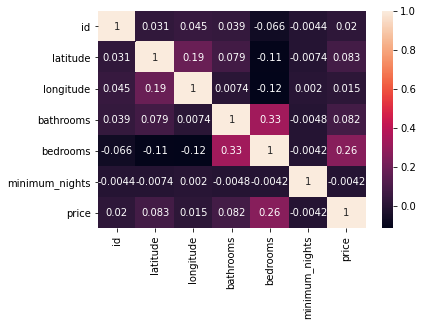

In [31]:
#plotting heatmap to check correlation between features 
sns.heatmap(df[numerical_columns].corr(),annot=True)
plt.show()

# Model Fitting


#### Feature Engineering

We will drop the id feature. Perform one hot encoding on categorical columns and scaling operation on the numerical variables.  


In [32]:
Target_feature="price"
print(f"categorical columns:{categorical_columns}")
feature_to_be_removed=[Target_feature,"id"]
for j in feature_to_be_removed:
    numerical_columns.remove(j)
print(f"Numerical columns:{numerical_columns}")

categorical columns:['property_type', 'room_type']
Numerical columns:['latitude', 'longitude', 'bathrooms', 'bedrooms', 'minimum_nights']


In [33]:
X=df.drop(["id",Target_feature],axis=1)
y=df[Target_feature]

In [34]:
#creating preprocessing pipeline for categorical columns
cat_pipeline= Pipeline(steps=[('one_Hot_encoder',OneHotEncoder(sparse=False,handle_unknown="ignore")),('scaling',StandardScaler(with_mean=False))])
#creating preprocessing pipeline for numerical columns
num_pipeline=Pipeline(steps=[('scaling',StandardScaler())])

In [35]:
#creating preprocessing object using column transformer
preprocessing=ColumnTransformer([('num_pipeline',num_pipeline,numerical_columns),('cat_pipeline',cat_pipeline,categorical_columns)])

In [36]:
#splitting data
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [37]:
#Transforming X_train and X_test
input_feature_train_arr = preprocessing.fit_transform(X_train)
input_feature_test_arr = preprocessing.transform(X_test)

# Model Evaluation

In [42]:
models= [("Linear Regression",LinearRegression()),("Xgboost Regressor",XGBRegressor()),\
         ("Random Forest Regressor",RandomForestRegressor())]

In [43]:
for name, model in models:

    %time model.fit(input_feature_train_arr, y_train)
    test_pred = model.predict(input_feature_test_arr)
    print(name ,'Mean absolute error : ',mean_absolute_error(y_test, test_pred))
    print('-----------------------------------------------------------------------')

CPU times: user 10.5 ms, sys: 34.9 ms, total: 45.5 ms
Wall time: 7.63 ms
Linear Regression Mean absolute error :  14666234532.834219
-----------------------------------------------------------------------
CPU times: user 6.03 s, sys: 104 ms, total: 6.13 s
Wall time: 3.12 s
Xgboost Regressor Mean absolute error :  94.06580739115317
-----------------------------------------------------------------------
CPU times: user 2.29 s, sys: 14 ms, total: 2.31 s
Wall time: 2.31 s
Random Forest Regressor Mean absolute error :  96.00025878003696
-----------------------------------------------------------------------


##### Hyperpararmeter tuning

Since Xgboost regressor was giving the leas mean absolute error. Randomised searchcv was performed to get the best parameters for the model so that the error is least.

In [40]:
mod_XG=XGBRegressor()
#define model evaluation method
param_grid={
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.0005,0.3,0.0005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01)
}
cv = RandomizedSearchCV(mod_XG,param_distributions=param_grid,scoring='neg_mean_absolute_error',n_jobs=-1,cv=3,verbose=10)

In [41]:
cv.fit(input_feature_train_arr,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0

In [46]:
print(f"best_score :{cv.best_score_}")
print(f"best parameters:{cv.best_params_}")

best_score :-90.67129782696422
best parameters:{'subsample': 0.75, 'min_child_weight': 0.1581, 'max_depth': 6, 'learning_rate': 0.038, 'gamma': 7.42, 'colsample_bytree': 0.8599999999999995, 'colsample_bylevel': 1.0}


In [48]:
cv_pred=cv.predict(input_feature_test_arr)
print('Mean absolute error : ',mean_absolute_error(y_test, cv_pred))

Mean absolute error :  91.84147335435605


# Business Metrics

Mean absolute error is used as Key Performance Indicator to compare model performance with respect to the business success criteria i.e  the predicted price should not be off by 25 dollars.
Xgboost Regressor model predicts the rent price with least mean absolute error.

# Business Focus
The current business problem is a regression problem.
The Xgboost regressor model created will  help customers to estimate the the amount they can earn by renting out their property. However the model created predicts prices that are on an average $91 away from actual prices.
## Recommendations
There are 8111 properties which are divided in to 26 property types however only 1 dataset exists for Camper/RV ,In-law,Dome house,Hut each. Also there is weak correlation between input features and price.Therefore there is the need to add better quantifiable predictors in order to increase the accuracy of the suggested model and reduce the error.